In [1]:
# Lab 07– Classification Models
# Learning Outcomes
# By the end of this lab, students will be able to:
# Train Naïve Bayes and SVM
# Evaluate models using accuracy, ROC AUC, and confusion matrix.
# P — Project
# Preprocess Churn dataset
# Train/test split.
# Fit:
# Naïve Bayes and SVM
# Compare accuracy, ROC AUC, confusion matrices
# Resources
# Sklearn Model Evaluation – https://scikitlearn. org/stable/modules/model_evaluation.html
# Confusion Matrix in Sklearn – https://scikitlearn.
# org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [2]:
# IMPORTS 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load churn dataset
file_path = 'LabAssig5_stuff/churn.csv'
df = pd.read_csv(file_path)

# Display first rows
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [3]:
# PREPROCESS

# Drop rows with missing target
df = df.dropna(subset=["Churn"])

# Normalize target to binary integers
df["Churn"] = df["Churn"].astype(str).str.strip().str.lower()
y = df["Churn"].map({
    'true': 1, 'false': 0, 'yes': 1, 'no': 0, 'y': 1, 'n': 0, '1': 1, '0': 0
}).astype(int)

# Remove any rows where target mapping resulted in NaN
valid_index = y.dropna().index

# Align features and target
X = df.drop(columns=["Churn"]).loc[valid_index]
y = y.loc[valid_index]

# Identify numeric and categorical feature columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"# numeric columns: {len(num_cols)}, # categorical columns: {len(cat_cols)}")

num_transformer = StandardScaler()

try:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols) if num_cols else ("num", "drop", []),
        ("cat", cat_transformer, cat_cols) if cat_cols else ("cat", "drop", []),
    ],
    remainder='drop'
)

# numeric columns: 16, # categorical columns: 3


In [4]:
# TRAIN TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 533, Testing samples: 134


In [5]:
# NAIVE BAYES MODEL

nb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", GaussianNB())
])

nb_pipeline.fit(X_train, y_train)
print("Naive Bayes model trained.")

Naive Bayes model trained.


In [6]:
# SUPPORT VECTOR MACHINE MODEL

svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", SVC(probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
print("SVM model trained.")

SVM model trained.



--- Naive Bayes Evaluation ---
Accuracy: 0.3060
ROC AUC: 0.5517
Confusion Matrix:
[[24 91]
 [ 2 17]]


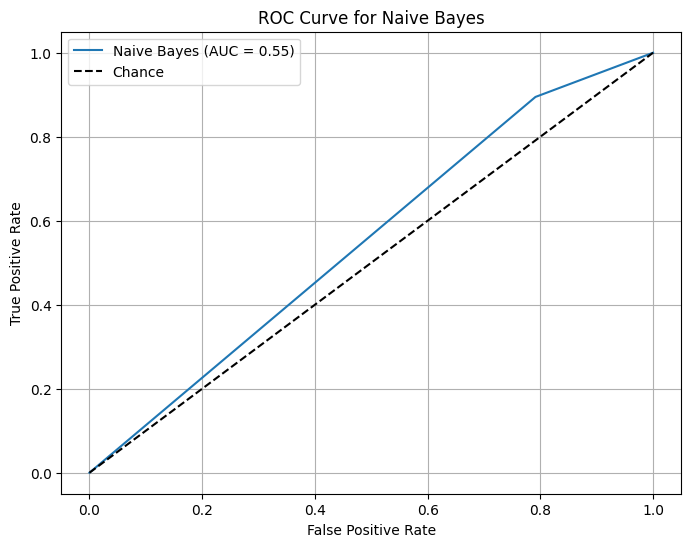


--- SVM Evaluation ---
Accuracy: 0.9030
ROC AUC: 0.9263
Confusion Matrix:
[[115   0]
 [ 13   6]]


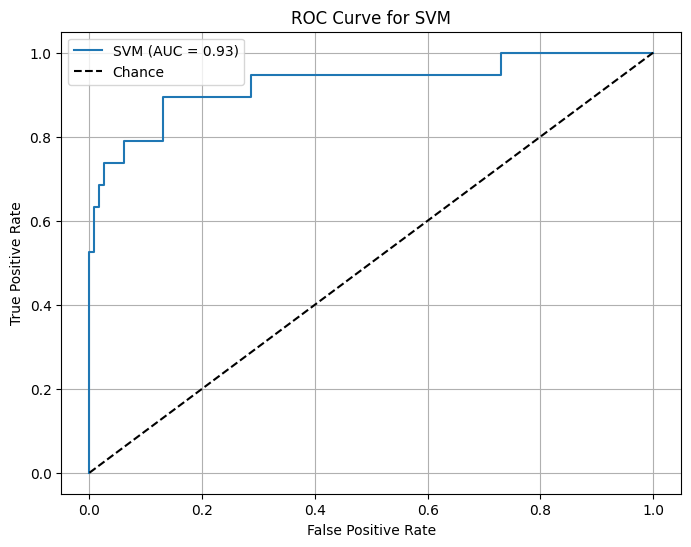

In [7]:
# MODEL EVALUATION

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_mat = confusion_matrix(y_test, y_pred)

    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_mat)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


evaluate_model(nb_pipeline, X_test, y_test, 'Naive Bayes')
evaluate_model(svm_pipeline, X_test, y_test, 'SVM')

In [8]:
# MODEL METRICS 

results = []
for model, name in [(nb_pipeline, 'Naive Bayes'), (svm_pipeline, 'SVM')]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results.append({'Model': name, 'Accuracy': acc, 'ROC AUC': auc})

metrics_df = pd.DataFrame(results)
print(metrics_df)

         Model  Accuracy   ROC AUC
0  Naive Bayes  0.305970  0.551716
1          SVM  0.902985  0.926316
